# This code is to summarize the statistical results related to phase precession of turning angle. Experimental data is based on Lomi et al, 2023. This code is written by Zilong Ji, 2024.

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from numpy import deg2rad
from scipy.optimize import curve_fit
from scipy.ndimage import convolve1d
from scipy.stats import mannwhitneyu, wilcoxon, pearsonr, spearmanr

import sys
sys.path.append('/home/zilong/Desktop/HDPhasePrecession/CircularLinearReg')
from core import cl_corr
import HD_utils

import pickle

%load_ext autoreload
%autoreload 2


In [2]:
def sinmodel(t, a, b, c, omega, t1, t2):
    return (a * (np.sin(2*np.pi*omega * t + np.pi/2) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2) 

def calculate_intrinsic_frequency(autocorrelogram):

    # Fit the model to the autocorrelogram data
    initial_guess = [1, 1, 0.1, 9, 1.0, 0.01]  # Initial guesses for a, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 6, 0, 0], [100, 100, 0.8, 12, 8, 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    #normalze autocorr to 0-1
    lags = autocorrelogram[1, :] / 1000.  # Convert lags to seconds

    params, _ = curve_fit(sinmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    # Extract the intrinsic frequency (omega)
    intrinsic_frequency = params[3]
    print(f"Intrinsic Theta Frequency: {intrinsic_frequency:.2f} Hz")
    
    return intrinsic_frequency, params

def skipmodel(t, a1, a2, b, c, omega, t1, t2):
    return (a1 * (np.cos(omega * t) + 1) + a2 * (np.cos(0.5*omega * t) + 1) + b) * np.exp(-np.abs(t) / t1) + c * np.exp(-t**2 / t2**2)

def calculate_skipping_index(autocorrelogram):
    # Fit the model to the autocorrelogram data
    initial_guess = [0.5, 0.5, 0.1, 0.1, 2 * 8 * np.pi, 0.01, 0.01]  # Initial guesses for a1, a2, b, c, omega, t1, t2
    bounds = ([0, 0, 0, 0, 12*np.pi, 0, 0], [100, 100, 100, 0.8, 24*np.pi, 8., 0.05])  # Bounds for the parameters

    autocorr = autocorrelogram[0, :]
    lags = autocorrelogram[1, :] / 1000  # Convert lags to seconds

    params, covariance = curve_fit(skipmodel, lags, autocorr, p0=initial_guess, bounds=bounds)
    omega = params[4] #freq

    # Calculate p1 and p2
    p1 = skipmodel(2 * np.pi / omega, *params)
    p2 = skipmodel(4 * np.pi / omega, *params)

    # Calculate the theta cycle skipping index
    TS = (p2 - p1) / max(p1, p2)
    
    print(f"Omega: {omega / (2 * np.pi):.2f} Hz")
    print(f"Theta Cycle Skipping Index: {TS:.2f}")
    
    return omega, TS, params  # Return frequency in Hz and the TS index

def get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config, restrict_angle=None):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    if restrict_angle is not None:
        #keep the points psph_combined is between [np.pi-pi/4. np.pi+pi/4]
        idx = np.where((psph_combined > np.pi - restrict_angle + np.pi/6) & (psph_combined < np.pi + restrict_angle + np.pi/6))[0]
        psph_combined = psph_combined[idx]
        spike_phase_combined = spike_phase_combined[idx]
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=1/2/np.pi, bootstrap_iter=1000, return_pval=True)
    

    return pval, circ_lin_corr

def plot_autocorrelogram(ax, autocorrelogram):
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')
    #fill between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorr, color='k', alpha=1.0)

    intrinsic_frequency, params = calculate_intrinsic_frequency(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
    #get the predicted y one by one
    y = []
    for i in range(len(t)):
        y.append(sinmodel(t[i], *params))
        
    ax.plot(t*1000, sinmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=10)
    ax.set_ylabel('Autocorrelation', fontsize=10)
     
    return ax, intrinsic_frequency

def plot_thetaskipping(ax, autocorrelogram):
    
    labelsize = 10
    ticksize = 8
    
    autocorr = autocorrelogram[0, :]

    ax.plot(autocorrelogram[1,:], autocorr, color='k', label='Autocorrelogram')
    #fill between y=0 and autocorrelogram
    ax.fill_between(autocorrelogram[1,:], 0, autocorr, color='k', alpha=1.0)

    omega, TS, params = calculate_skipping_index(autocorrelogram)

    #plot the fitted curve
    t = autocorrelogram[1,:]/1000
        
    ax.plot(t*1000, skipmodel(t, *params), color='red', label='Fitted curve', linewidth=1)
    
    #ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
    
    ax.set_xticks([-500, 0, 500])   
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False) 
    
    ax.set_xlabel('Lag (ms)', fontsize=labelsize)
    #ax.set_ylabel('Autocorrelation', fontsize=labelsize)
    ax.set_title('TS: ' + str(np.round(TS, 2)), fontsize=labelsize)
    
    #set x and y tick fontsize to 8
    ax.tick_params(axis='x', which='major', labelsize=ticksize)
    ax.tick_params(axis='y', which='major', labelsize=ticksize)
    
    
    return ax, TS

def plot_head_direction_tuning(ax, ppoh, psph, config, pos_tb=0.02):
    """
    Plot the head direction tuning map in a polar plot.

    Parameters:
    ax : matplotlib.axes._subplots.PolarAxesSubplot
        The polar axes to plot on.
    ppoh : np.array
        Array of session head direction angles in degrees.
    psph : np.array
        Array of cell head direction angles in degrees.
    pos_tb : float
        Time base for converting session HD to time.
    cell_name : str
        Name of the cell for which the tuning map is plotted.
    config : dict
        Configuration dictionary containing 'hd_bins' and 'hd_boxcar' parameters.
    """

    # Convert angles to radians
    ppoh_rad = deg2rad(ppoh)
    psph_rad = deg2rad(psph)

    # Calculate histograms for session and cell head directions
    hd1, _ = np.histogram(ppoh_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))
    hd2, _ = np.histogram(psph_rad, bins=config['hd_bins'], range=(0, 2 * np.pi))

    # Boxcar filter
    boxcar_size = config['hd_boxcar']
    boxcar_filter = np.ones(boxcar_size) / boxcar_size

    # Apply boxcar filter
    hd1_filtered = convolve1d(hd1, boxcar_filter, mode='wrap')
    hd2_filtered = convolve1d(hd2, boxcar_filter, mode='wrap')

    # Convert session HD to time (i.e., dwelling time in each HD bin)
    hd1_time = hd1_filtered * pos_tb

    # Calculate HD firing rate
    hd3 = hd2_filtered / hd1_time

    # Normalize session HD
    hd1_normalized = hd1_time / np.max(hd1_time)

    # Normalize cell HD firing rate
    hd3_normalized = hd3 / np.max(hd3)
    hd3_normalized = hd3_normalized.flatten()

    # Close the loop by appending the first element to the end
    theta = np.linspace(0, 2 * np.pi, config['hd_bins'], endpoint=False)
    theta = np.append(theta, theta[0])
    hd1_normalized = np.append(hd1_normalized, hd1_normalized[0])
    hd3_normalized = np.append(hd3_normalized, hd3_normalized[0])

    # Plot the session head direction with shading
    ax.plot(theta, hd1_normalized, label='Session Head Direction', color='gray')
    ax.fill_between(theta, 0, hd1_normalized, facecolor='gray', alpha=0.2)

    # Plot the cell head direction firing rate
    ax.plot(theta, hd3_normalized, label='Cell Head Direction Firing Rate', color='#38c7ff')
    ax.fill_between(theta, 0, hd3_normalized, facecolor='#38c7ff', alpha=0.5)

    #keep 0 90 180 270 as the xticks
    ax.set_xticks([0, np.pi / 2, np.pi, 3 * np.pi / 2])
    ax.set_xticklabels(['0°', '90°', '180°', '270°'])
    
    #remove yticks
    ax.set_yticks([])
    
    #ax.set_title(cell_name + '\n'+str(np.round(hd_mean,1))+'('+str(np.round(hd_std,1))+')' +'\nRayleigh_p=' + str(np.round(pval, 4)), fontsize=10)
    
    #ax.set_title(f"{cell_name}\nAngle:{hd_mean:.0f} ({hd_std:.0f})\nTuning width:{tune_width:.0f}\nRayleigh_p={pval:.4f}", fontsize=10)
    # ax.legend()
    #set x and y tick as 8 pt
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)

    return ax


def plot_phaseprecession(ax, ppoh, pot, pspt, psph, hd_mean, spike_phase, config, addfitline=True):
    
    spike_phase = spike_phase + np.pi #[-pi, pi] -> [0, 2pi]
    
    alpha = 0.4
    speed_threshold = config['speed_threshold']
    duration_threshold = config['duration_threshold']
    speed_smooth_sigma = config['speed_smooth_sigma']
    
    #calculate angular speed
    angular_speed = HD_utils.calculate_angular_speed(ppoh, pot, sigma=speed_smooth_sigma)
    
    #convert psph to radian
    psph = deg2rad(psph)
    hd_mean = deg2rad(hd_mean)
    
    psph_centered = np.mod(psph - hd_mean + np.pi, 2 * np.pi)
    
    #CCW plot in ax1
    continuous_periods_CCW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=-speed_threshold, duration_threshold=duration_threshold)
    indx = []
    for i in range(len(continuous_periods_CCW)):
        indx.extend(np.where((pspt > continuous_periods_CCW[i][0]) & (pspt < continuous_periods_CCW[i][1]))[0])
        
    psph_CCW = psph_centered[indx]
    spike_phase_CCW = spike_phase[indx]
    
    
    #CW plot in ax2
    continuous_periods_CW = HD_utils.find_continuous_periods(angular_speed, pot, speed_threshold=speed_threshold, duration_threshold=duration_threshold)
    #keep the index when pspt is within continuous_periods
    indx = [] 
    for i in range(len(continuous_periods_CW)):
        indx.extend(np.where((pspt > continuous_periods_CW[i][0]) & (pspt < continuous_periods_CW[i][1]))[0])
    
    psph_CW = psph_centered[indx]
    spike_phase_CW = spike_phase[indx]
    
    
    #ax3 plot
    #flip   psph_CCW by 2pi - psph_CCW
    psph_CCW = 2 * np.pi - psph_CCW
    #combine CCW and CW togther and plot
    psph_combined = np.concatenate((psph_CCW, psph_CW))
    spike_phase_combined = np.concatenate((spike_phase_CCW, spike_phase_CW))
    
    circ_lin_corr, pval, slope, phi0, RR = cl_corr(psph_combined, spike_phase_combined, min_slope=-1/2/np.pi, max_slope=0, bootstrap_iter=3000, return_pval=True)

    #if len(psph_combined)>200 then random sample 200 points from it, otherwise plot all points
    if len(psph_combined) > np.inf:
        idx = np.random.choice(len(psph_combined), 200, replace=False)
        psph_combined = psph_combined[idx]
        spike_phase_combined = spike_phase_combined[idx]
         
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
    else:
        ax.scatter(psph_combined, spike_phase_combined, s=0.2, color='black', alpha=alpha)
        ax.scatter(psph_combined, [spike_phase_combined[i] + 2 * np.pi for i in range(len(spike_phase_combined))], s=0.2, color='black', alpha=alpha)
        

    if addfitline:
        # Plot the circular-linear regression
        x = np.linspace(0, 2 * np.pi, 100)
        y = 2 * np.pi * slope * x + phi0
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #add intercepr of 4*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 + 4 * np.pi
        ax.plot(x, y, color='red', linewidth=1)
        #substrac intercepr of 2*pi, and plot the line again
        y = 2 * np.pi * slope * x + phi0 - 2 * np.pi
        ax.plot(x, y, color='red', linewidth=1)   
    
    ax.set_title('CL Corr: ' + str(np.round(circ_lin_corr, 2)), fontsize=10)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    ax.set_xlim(0, 2*np.pi)
    ax.set_xticks([0, np.pi, 2*np.pi])
    ax.set_xticklabels(["$-\pi$", "$0$", "$\pi$"])
    
    ax.set_ylim(0, 4*np.pi)
    ax.set_yticks([0,  2*np.pi,  4*np.pi])
    ax.set_yticklabels(["$0$", "$2\pi$", "$4\pi$"])
    
    #set tick size as 8 using one line
    ax.tick_params(axis='both', labelsize=8)
    

    return ax, pval, circ_lin_corr

## Section 1: extract information and perform circular-linear correlation analysis

Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r448/R448_31032020_T2_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_200919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r651/R651_081019_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r762/R762_110119_T4_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r449/R449_27032020_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r222/R222_120319_T3_sdata.mat


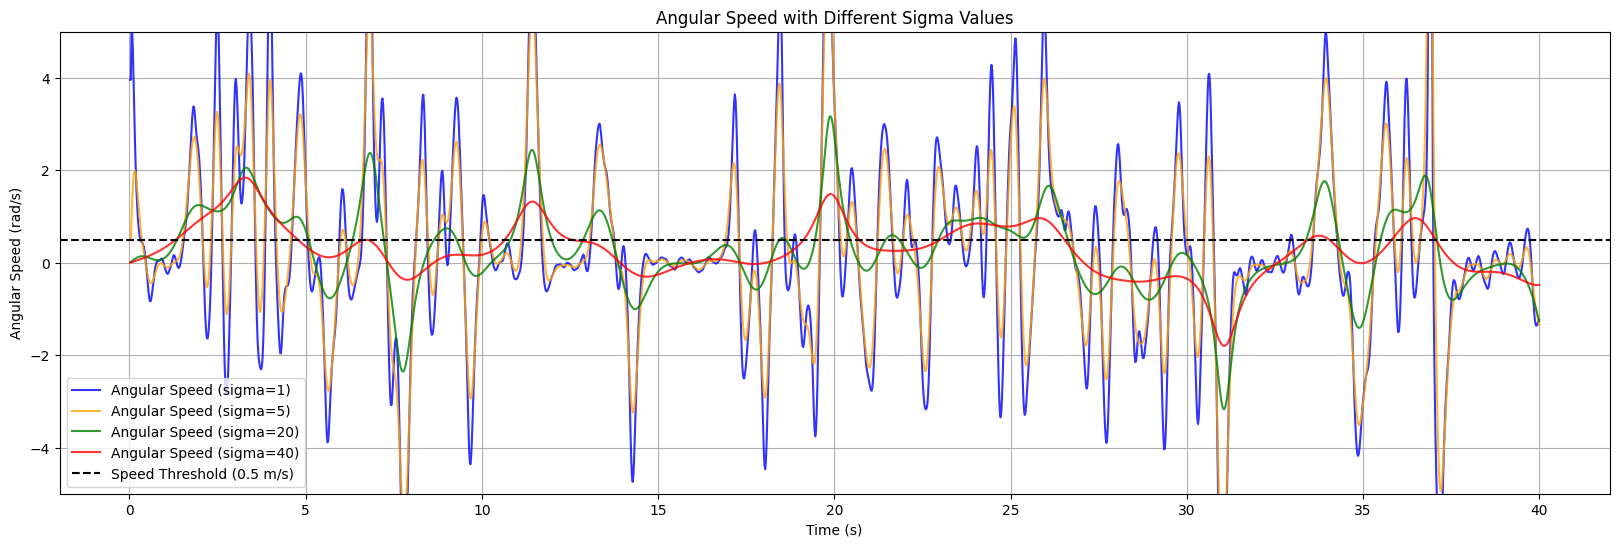

In [20]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'


# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 20, #40,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

total_hd_cells = 0

all_tw = []
nontheta_tw = []
theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []

all_peakfr = []
nontheta_peakfr = []
theta_peakfr = []
theta_nonskip_peakfr = []
theta_skip_peakfr = []

all_R = []
nontheta_R = []
theta_R = []
theta_nonskip_R = []
theta_skip_R = []

all_intrinsic_freq = []
nontheta_intrinsic_freq = []
theta_intrinsic_freq = []
theta_nonskip_intrinsic_freq = []
theta_skip_intrinsic_freq = []

all_global_freq = []
nontheta_global_freq = []
theta_global_freq = []
theta_nonskip_global_freq = []
theta_skip_global_freq = []

all_ppp = []
nontheta_ppp = []
theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []

all_clr = []
nontheta_clr = []
theta_clr = []
theta_nonskip_clr = []
theta_skip_clr = []
hd_clr = []

matnames = {}

phaseinfo = {}


speed_smooth_sigma = 20 

ind=0

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    angular_speed1 = HD_utils.calculate_angular_speed(ppoh, pot, sigma=0.5)
                    angular_speed2 = HD_utils.calculate_angular_speed(ppoh, pot, sigma=5)
                    angular_speed3 = HD_utils.calculate_angular_speed(ppoh, pot, sigma=20)
                    angular_speed4 = HD_utils.calculate_angular_speed(ppoh, pot, sigma=40)
                    
                    ind += 1
                    
                    if ind > 1:
                        break


#plot angular speed1, 
plt.figure(figsize=(20, 6))

start = 0
end = 2000
plt.plot(pot[start:end], angular_speed1[start:end], label='Angular Speed (sigma=1)', color='blue', alpha=0.8)
plt.plot(pot[start:end], angular_speed2[start:end], label='Angular Speed (sigma=5)', color='orange', alpha=0.8)
plt.plot(pot[start:end], angular_speed3[start:end], label='Angular Speed (sigma=20)', color='green', alpha=0.8)
plt.plot(pot[start:end], angular_speed4[start:end], label='Angular Speed (sigma=40)', color='red', alpha=0.8)

#add y=0.5 dashed line
plt.axhline(y=0.5, color='black', linestyle='--', label='Speed Threshold (0.5 m/s)')

plt.xlabel('Time (s)')
plt.ylabel('Angular Speed (rad/s)')
plt.title('Angular Speed with Different Sigma Values')
plt.legend()
plt.grid()

plt.ylim(-5, 5)

plt.show()



In [7]:
angular_speed1.shape

(23999,)

## Section1.2: comapre tuning width and peak fr and rayleigh vector length between different groups

In [4]:
# print tuning width, peak fr, and rayleigh vector length of each group
print('Tuning witdh of theta modulated cells:', np.mean(theta_tw), np.std(theta_tw))
print('Tuning width of HD cells:', np.mean(nontheta_tw), np.std(nontheta_tw))
#manwhitneyu test
print(mannwhitneyu(theta_tw, nontheta_tw))

print('*'*50)
print('Rayleigh vector length of theta modulated cells:', np.mean(theta_R), np.std(theta_R))
print('Rayleigh vector length of HD cells:', np.mean(nontheta_R), np.std(nontheta_R))
#manwhitneyu test
print(mannwhitneyu(theta_R, nontheta_R))

print('*'*50)
print('Peak firing rate of theta modulated cells:', np.mean(theta_peakfr), np.std(theta_peakfr))
print('Peak firing rate of HD cells:', np.mean(nontheta_peakfr), np.std(nontheta_peakfr))
#manwhitneyu test
print(mannwhitneyu(theta_peakfr, nontheta_peakfr))

Tuning witdh of theta modulated cells: 137.8441642310493 19.600064814406014
Tuning width of HD cells: 117.05379950363722 32.23961826712023
MannwhitneyuResult(statistic=21530.0, pvalue=2.4986924552697797e-11)
**************************************************
Rayleigh vector length of theta modulated cells: 0.2618672072594209 0.18152452565600952
Rayleigh vector length of HD cells: 0.4387048993845388 0.256990746492642
MannwhitneyuResult(statistic=8798.0, pvalue=2.4986924552697797e-11)
**************************************************
Peak firing rate of theta modulated cells: 7.348626140861124 10.626093117686487
Peak firing rate of HD cells: 10.318356801626965 18.037996258838874
MannwhitneyuResult(statistic=16367.0, pvalue=0.20742655962542056)


## Section 2: get the percentage of HD cells with significant phase precession of turning angle

ratio of pp in theta skipping cells: 0.21333333333333335
ratio of pp in theta non-skipping cells 0.0945945945945946
ratio of pp in classic HD cells 0.051470588235294115
theta skip cells:16/75
theta nonskip cells:14/148
nontheta HD cells:7/136
total HD cells: 359
total theta modulated HD cells: 223
all cells showing phase precession: 37
tmHDCs showing phase precession: 30
0.10306406685236769
0.13452914798206278


/tmp/ipykernel_3182806/2890434245.py:66: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=labelsize, va='center')


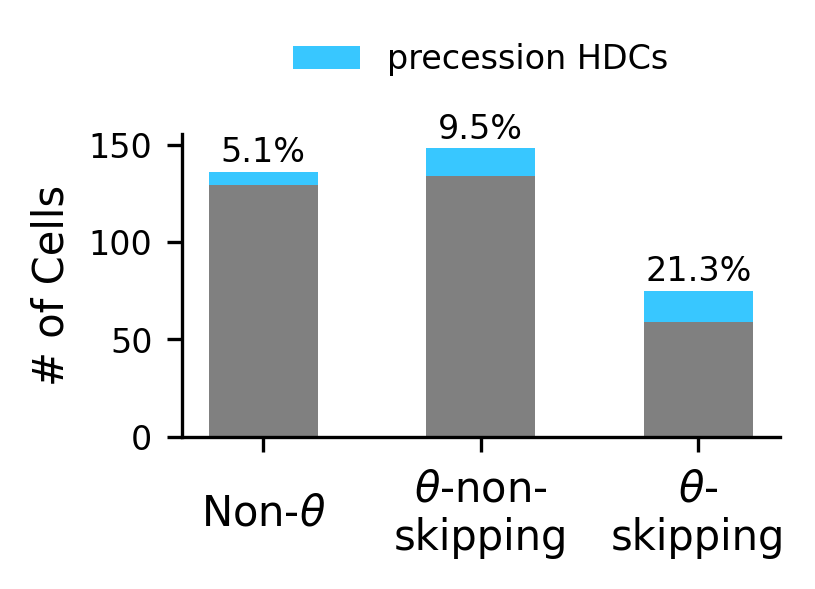

In [5]:
# ratio of pval_skip<0.05
# Create arrays for p-values
pval_skip = np.array(theta_skip_ppp)
pval_nonskip = np.array(theta_nonskip_ppp)
pval_nontheta = np.array(nontheta_ppp)

clr_skip = np.array(theta_skip_clr)
clr_nonskip = np.array(theta_nonskip_clr)
clr_nontheta = np.array(nontheta_clr)

# Calculate counts for p-values less than and greater than 0.05
skip_p_less = len(pval_skip[(pval_skip < 0.05) & (clr_skip <0)])
skip_p_more = len(pval_skip) - skip_p_less

nonskip_p_less = len(pval_nonskip[(pval_nonskip < 0.05) & (clr_nonskip <0)])
nonskip_p_more = len(pval_nonskip) - nonskip_p_less

nontheta_p_less = len(pval_nontheta[(pval_nontheta < 0.05) & (clr_nontheta <0)])
nontheta_p_more = len(pval_nontheta) - nontheta_p_less

# Print ratios
print('ratio of pp in theta skipping cells:', skip_p_less / len(pval_skip))
print('ratio of pp in theta non-skipping cells', nonskip_p_less / len(pval_nonskip))
print('ratio of pp in classic HD cells', nontheta_p_less / len(pval_nontheta))

#print the number of cells
print('theta skip cells:%d/%d' % (skip_p_less, len(theta_skip_ppp)))
print('theta nonskip cells:%d/%d' % (nonskip_p_less, len(theta_nonskip_ppp)))
print('nontheta HD cells:%d/%d' % (nontheta_p_less, len(nontheta_ppp)))
print('total HD cells:', total_hd_cells)   
print('total theta modulated HD cells:', len(theta_ppp))
print('all cells showing phase precession:', skip_p_less+nonskip_p_less+nontheta_p_less)
print('tmHDCs showing phase precession:', skip_p_less+nonskip_p_less)
print((skip_p_less+nonskip_p_less+nontheta_p_less)/total_hd_cells)
print((skip_p_less+nonskip_p_less)/len(theta_ppp))



# Data for bar plot
categories = ['Non-'+r'$\theta$', r'$\theta$'+'-non-'+'\nskipping', r'$\theta$'+'-'+'\nskipping']
less_than_005 = [nontheta_p_less, nonskip_p_less, skip_p_less]
more_than_005 = [nontheta_p_more, nonskip_p_more, skip_p_more]

# Calculate percentages
total_cells = [nontheta_p_less + nontheta_p_more, nonskip_p_less + nonskip_p_more, skip_p_less + skip_p_more]
percent_less_than_005 = [100 * less / total for less, total in zip(less_than_005, total_cells)]
percent_more_than_005 = [100 * more / total for more, total in zip(more_than_005, total_cells)]

# Create stacked bar plot
fig, ax = plt.subplots(figsize=(2.8, 2.4), dpi=300)

labelsize = 10
ticksize = 8

bar_width = 0.5
bar1 = ax.bar(categories, more_than_005, bar_width, color='grey')
#label ha center, va center
bar2 = ax.bar(categories, less_than_005, bar_width, bottom=more_than_005, label='precession HDCs', color='#38c7ff')


ax.legend(frameon=False, loc='upper center', fontsize=8, bbox_to_anchor=(0.5, 1.4))

# Add labels and title
ax.set_ylabel('# of Cells', fontsize=labelsize)
#roatte xlabel 45 degree
ax.set_xticklabels(categories, rotation=0, ha='center', fontsize=labelsize, va='center')
#move xlabel closer to the plot
ax.tick_params(axis='x', pad=15)

# Add percentages on top of the higher bars
for i, (less, more, total) in enumerate(zip(less_than_005, more_than_005, total_cells)):
    ax.text(i, more + less + 10, f'{percent_less_than_005[i]:.1f}%', ha='center', va='center', color='black', fontsize=ticksize)

#tickfontsize
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/phaseprecession_percentage.pdf')

### check the distribution of clcc for all HDCs

TtestResult(statistic=-5.026061623192926, pvalue=1.0300034703355237e-06, df=222)


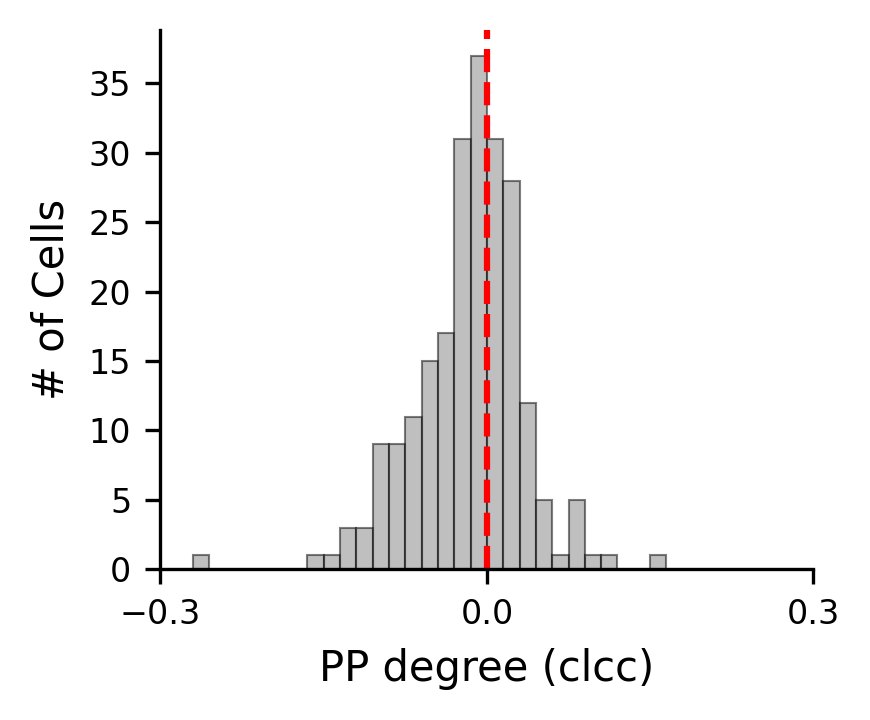

In [6]:
#shitogram plot of the cl_corr
fig, ax = plt.subplots(figsize=(3, 2.5), dpi=300)

labelsize = 10
ticksize = 8

# Create histograms
bins = np.linspace(-0.3, 0.3, 41)
ax.hist(hd_clr, bins=bins, color='grey', alpha=0.5, edgecolor='black', linewidth=0.5)
#add x=0 line
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.5)

ax.set_ylabel('# of Cells', fontsize=labelsize)
ax.set_xlabel('PP degree (clcc)', fontsize=labelsize)
ax.set_xticks([-0.3, 0, 0.3])
ax.set_xlim(-0.3, 0.3)

#ticksize 
ax.tick_params(axis='both', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/phaseprecession_hist.pdf')
#perform an one sample t-test to test if the mean of the clcc is significantly different from 0
from scipy.stats import ttest_1samp
#print stats and p-value
print(ttest_1samp(hd_clr, 0))



### proportion z-test

In [7]:
#perform a two-proportion z-test for ratio of pp in theta skipping cells and ratio of pp in theta non-skipping cells

from statsmodels.stats.proportion import proportions_ztest

count = np.array([skip_p_less, nonskip_p_less])
nobs = np.array([len(theta_skip_ppp), len(theta_nonskip_ppp)])

stat, pval = proportions_ztest(count, nobs)
print('p-value for two-proportion z-test:', pval)
print('stat:', stat)    

print('*'*50)

# one sample proportion test of non-theta modulated HD cells
count = nontheta_p_less
nobs = len(nontheta_ppp)
stat, pval = proportions_ztest(count, nobs, value=0.05) 
print('p-value for one-sample proportion z-test:', pval)
print('stat:', stat)


p-value for two-proportion z-test: 0.014085008843944159
stat: 2.455088039381747
**************************************************
p-value for one-sample proportion z-test: 0.9381329008208545
stat: 0.07761677160037976


### chi-square test

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import chi2_contingency, norm
from statsmodels.stats.multitest import multipletests


print('A: nontheta HD cells:%d/%d' % (nontheta_p_less, len(nontheta_ppp)))
print('B: theta nonskip cells:%d/%d' % (nonskip_p_less, len(theta_nonskip_ppp)))
print('C: theta skip cells:%d/%d' % (skip_p_less, len(theta_skip_ppp)))


# Observed data
data = np.array([
    [nontheta_p_less, len(nontheta_ppp)-nontheta_p_less],  # Group A: showing feature, not showing feature
    [nonskip_p_less, len(theta_nonskip_ppp)-nonskip_p_less],  # Group B
    [skip_p_less, len(theta_skip_ppp)-skip_p_less],   # Group C
])


# Group sizes and proportions
n_A, n_B, n_C = len(nontheta_ppp), len(theta_nonskip_ppp), len(theta_skip_ppp)
p_A, p_B, p_C = nontheta_p_less/n_A, nonskip_p_less/n_B, skip_p_less/n_C

# Chi-square test
chi2_stat, p_val, dof, expected = chi2_contingency(data)
print(f"Chi-square test statistic: {chi2_stat}")
print(f"P-value: {p_val}")
print(f"Degrees of freedom: {dof}")

# Pairwise proportion z-tests
def pairwise_proportion_test(p1, n1, p2, n2):
    pooled_p = (p1 * n1 + p2 * n2) / (n1 + n2)
    z = (p1 - p2) / np.sqrt(pooled_p * (1 - pooled_p) * (1/n1 + 1/n2))
    p_value = 2 * (1 - norm.cdf(abs(z)))  # Two-tailed test
    return z, p_value

pairwise_results = []
groups = ['A', 'B', 'C']
proportions = [p_A, p_B, p_C]
sizes = [n_A, n_B, n_C]

# Calculate pairwise tests
for i in range(len(groups)):
    for j in range(i+1, len(groups)):
        z, p = pairwise_proportion_test(proportions[i], sizes[i], proportions[j], sizes[j])
        pairwise_results.append({'Comparison': f'{groups[i]} vs {groups[j]}', 'Z-Statistic': z, 'P-Value': p})

# Convert to DataFrame
pairwise_df = pd.DataFrame(pairwise_results)

# Apply Bonferroni correction
p_values = pairwise_df['P-Value'].values
corrected_p_values = multipletests(p_values, method='bonferroni')[1]
pairwise_df['Corrected P-Value'] = corrected_p_values

# Display results
print("\nPairwise Comparisons with Bonferroni Correction:")
print(pairwise_df)


A: nontheta HD cells:7/136
B: theta nonskip cells:14/148
C: theta skip cells:16/75
Chi-square test statistic: 13.896098938479701
P-value: 0.0009605068258326912
Degrees of freedom: 2

Pairwise Comparisons with Bonferroni Correction:
  Comparison  Z-Statistic   P-Value  Corrected P-Value
0     A vs B    -1.387366  0.165330           0.495991
1     A vs C    -3.611149  0.000305           0.000915
2     B vs C    -2.455088  0.014085           0.042255


## Section 3: get the circular-linear correlation coefficient for three types of HD cells

pval between nontheta and theta nonskip: 0.02705537942809145
pval between nontheta and theta skip: 0.03389482602509646
pval between theta nonskip and theta skip: 0.688472042945817


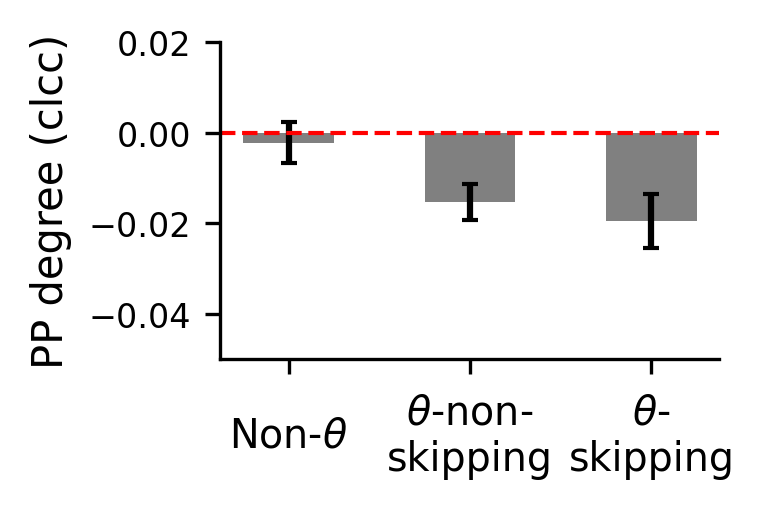

In [9]:
#plot clr for nontheta, theta nonskip, theta skip with mean and sem

# Create arrays for circ-linear correlation
clr_nontheta = np.array(nontheta_clr)
clr_theta_nonskip = np.array(theta_nonskip_clr)
clr_theta_skip = np.array(theta_skip_clr)

fig, ax = plt.subplots(1, 1, figsize=(2.6, 1.8), dpi=300)
labelsize = 10
ticksize = 8
# Plot the mean and standard error of the circ-linear correlation
mean_clr_nontheta = np.mean(clr_nontheta)
sem_clr_nontheta = np.std(clr_nontheta) / np.sqrt(len(clr_nontheta))
mean_clr_theta_nonskip = np.mean(clr_theta_nonskip)
sem_clr_theta_nonskip = np.std(clr_theta_nonskip) / np.sqrt(len(clr_theta_nonskip))
mean_clr_theta_skip = np.mean(clr_theta_skip)
sem_clr_theta_skip = np.std(clr_theta_skip) / np.sqrt(len(clr_theta_skip))

# Plot the bars
bar_width = 0.5
bar1 = ax.bar(['Non-theta', 'Theta-non-'+'\nskipping', 'Theta-\nskipping'], [mean_clr_nontheta, mean_clr_theta_nonskip, mean_clr_theta_skip], bar_width, yerr=[sem_clr_nontheta, sem_clr_theta_nonskip, sem_clr_theta_skip], capsize=2, color='grey')

#add y=0
ax.axhline(y=0, color='red', linestyle='--', linewidth=1.0)

#ylim
ax.set_ylim(-0.05, 0.02)
ax.set_yticks([-0.04, -0.02, 0, 0.02])

# Add labels and title
ax.set_ylabel('PP degree (clcc)', fontsize=labelsize)
#roatte xlabel 45 degree
ax.set_xticks([0, 1, 2])
ax.set_xticklabels(['Non-'+r'$\theta$', r'$\theta$'+'-non-'+'\nskipping', r'$\theta$'+'-'+'\nskipping'], rotation=0, ha='center', fontsize=labelsize-0.5, va='center')
#move xlabel closer to the plot
ax.tick_params(axis='x', pad=15)

#set y ticks fontsize to 8
ax.tick_params(axis='y', which='major', labelsize=ticksize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

#mannwhitneyu test between nontheta and theta nonskip
_, pval = mannwhitneyu(clr_nontheta, clr_theta_nonskip)
print('pval between nontheta and theta nonskip:', pval)

#mannwhitneyu test between nontheta and theta skip
_, pval = mannwhitneyu(clr_nontheta, clr_theta_skip)
print('pval between nontheta and theta skip:', pval)

#mannwhitneyu test between theta nonskip and theta skip
_, pval = mannwhitneyu(clr_theta_nonskip, clr_theta_skip)
print('pval between theta nonskip and theta skip:', pval)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/clr_coefficient_in_three_celltypes.pdf')


## Section 4: plot the intrinsic frequency against global frequency for three types of HD cells. Note that I delete cells with global freqeuncy hit the 7 HZ or 12 Hz boundary (I guess fitting failed in this case).

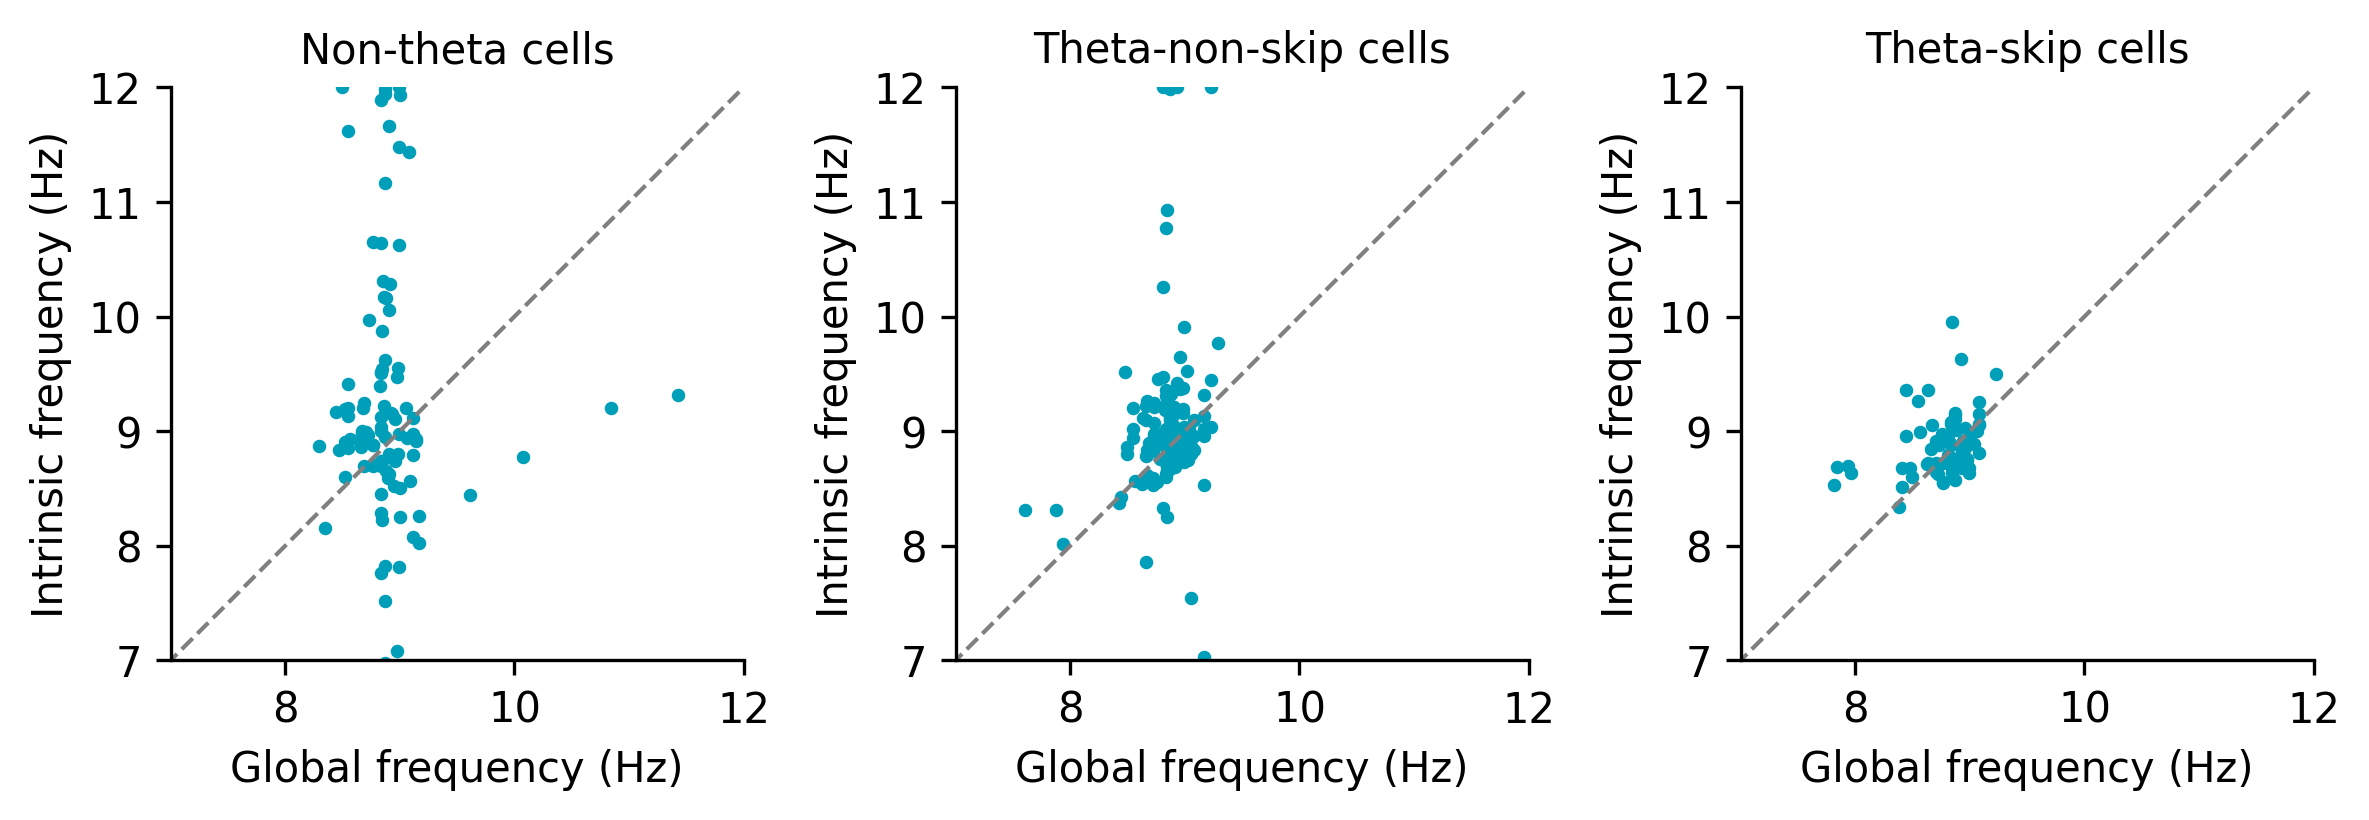

In [10]:


fig, axs = plt.subplots(1,3, figsize=(8, 3), dpi=300)

ax = axs[0]
#plot intrinsic freq against global freq for nontheta cells
#remove nontheta_global_freq when it is < 7.2
nontheta_global_freq = np.array(nontheta_global_freq)
nontheta_intrinsic_freq = np.array(nontheta_intrinsic_freq)
indx = np.where((nontheta_global_freq >= 7.2) & (nontheta_global_freq <=11.8))
ax.scatter(nontheta_global_freq[indx], 
           nontheta_intrinsic_freq[indx], 
           color='#009FB9', label='Non-theta', s=5)
ax.set_title('Non-theta cells', fontsize=labelsize)

ax = axs[1]
#plot intrinsic freq against global freq for theta nonskip cells
theta_nonskip_global_freq = np.array(theta_nonskip_global_freq)
theta_nonskip_intrinsic_freq = np.array(theta_nonskip_intrinsic_freq)
indx = np.where((theta_nonskip_global_freq >= 7.2) & (theta_nonskip_global_freq <=11.8))
ax.scatter(theta_nonskip_global_freq[indx], 
           theta_nonskip_intrinsic_freq[indx], 
           color='#009FB9', label='Theta-non-skip', s=5)
ax.set_title('Theta-non-skip cells', fontsize=labelsize)

ax = axs[2]
#plot intrinsic freq against global freq for theta skip cells
theta_skip_global_freq = np.array(theta_skip_global_freq)
theta_skip_intrinsic_freq = np.array(theta_skip_intrinsic_freq)
indx = np.where((theta_skip_global_freq >= 7.2) & (theta_skip_global_freq <=11.8))
ax.scatter(theta_skip_global_freq[indx], theta_skip_intrinsic_freq[indx], color='#009FB9', label='Theta-skip', s=5)
ax.set_title('Theta-skip cells', fontsize=labelsize)

for ax in axs:
    ax.set_xlim(7, 12)
    ax.set_ylim(7, 12)
    #equal aspect ratio
    ax.set_aspect('equal', 'box')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #add y=x line
    ax.plot([2, 13], [2, 13], color='grey', linestyle='--', linewidth=1.0)
    #x label
    ax.set_xlabel('Global frequency (Hz)', fontsize=labelsize)
    #y label
    ax.set_ylabel('Intrinsic frequency (Hz)', fontsize=labelsize)

plt.tight_layout()


## Section 4.2: plot intrinsic freq vs global freq specifically for significant phase precession cells

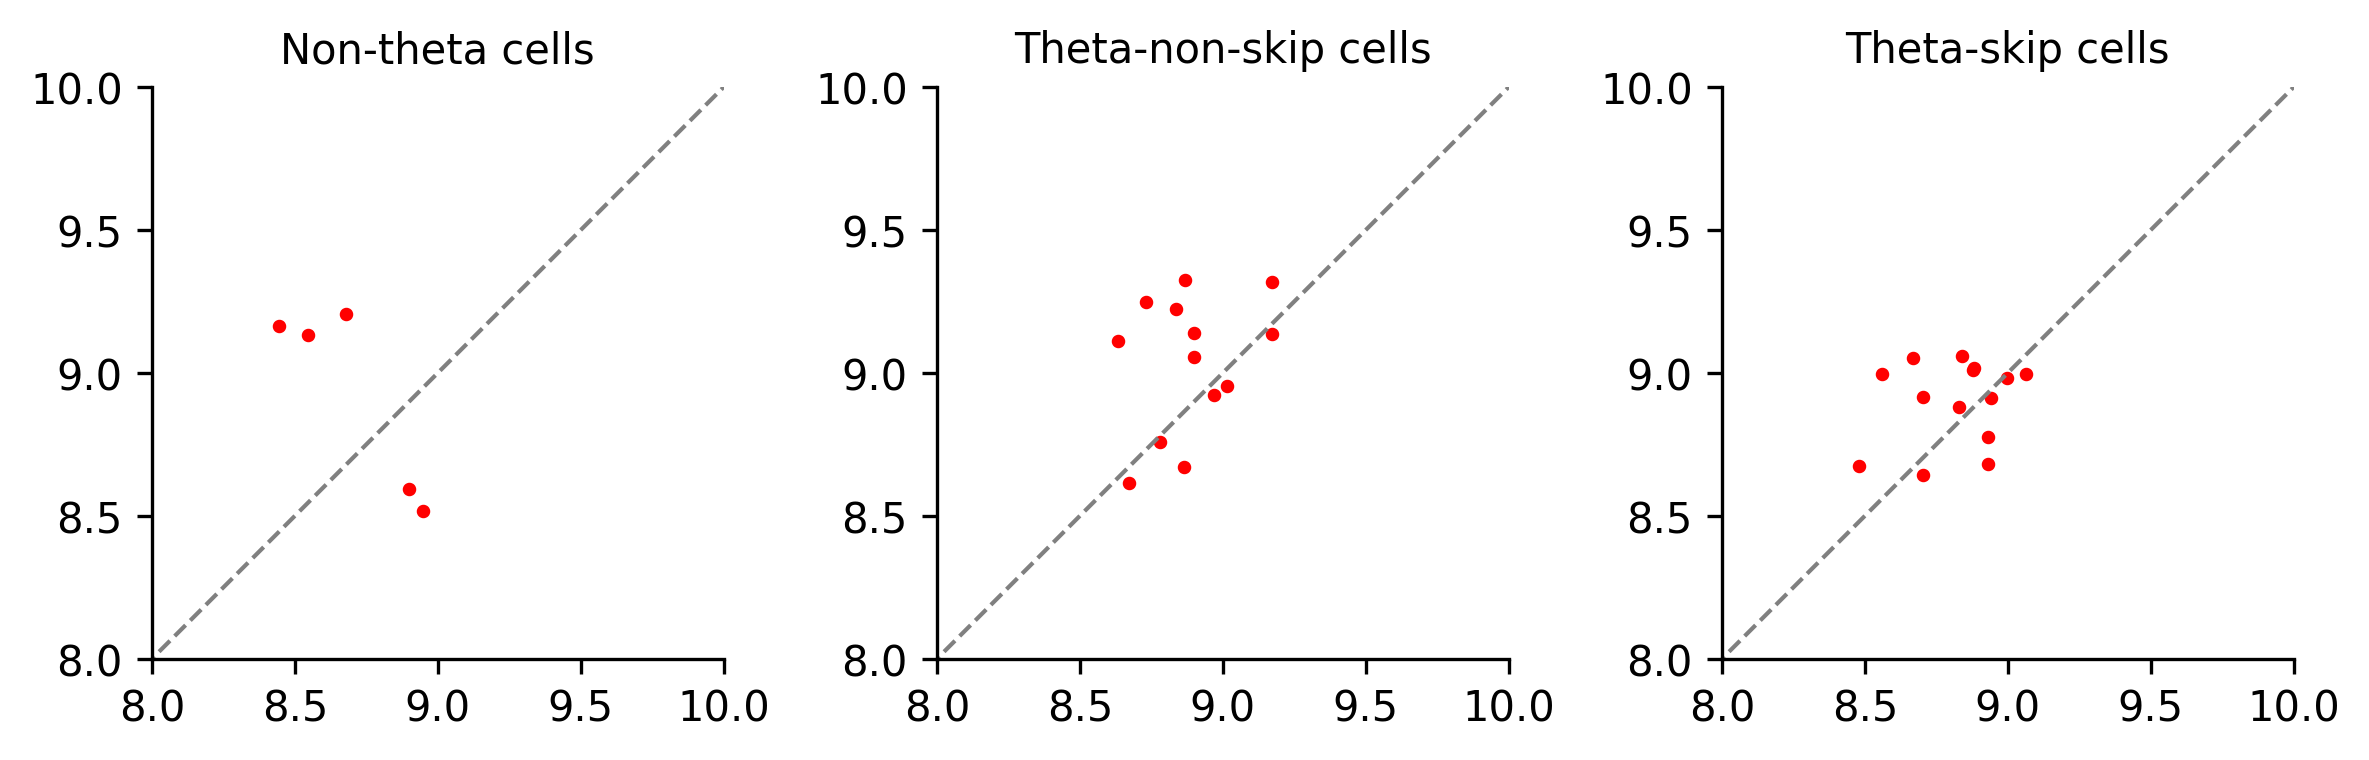

In [11]:
fig, axs = plt.subplots(1,3, figsize=(8, 3), dpi=300)

ax = axs[0]
#plot intrinsic freq against global freq for nontheta cells
#filter p < 0.05 and clr < 0 for nontheta_global_freq and nontheta_intrinsic_freq
indx = np.where((np.array(nontheta_ppp) < 0.05) 
                & (np.array(nontheta_clr) < 0)
                & (np.array(nontheta_global_freq) >= 7.2)
                & (np.array(nontheta_global_freq) <= 11.8))[0]
ax.scatter(np.array(nontheta_global_freq)[indx], 
           np.array(nontheta_intrinsic_freq)[indx], 
           color='red', label='Non-theta', s=5)
ax.set_title('Non-theta cells', fontsize=labelsize)

ax = axs[1]
#plot intrinsic freq against global freq for theta nonskip cells
#filter p < 0.05 for theta_nonskip_global_freq and theta_nonskip_intrinsic_freq
indx = np.where((np.array(theta_nonskip_ppp) < 0.05) 
                & (np.array(theta_nonskip_clr) < 0)
                & (np.array(theta_nonskip_global_freq) >= 7.2)
                & (np.array(theta_nonskip_global_freq) <= 11.8))[0]
ax.scatter(np.array(theta_nonskip_global_freq)[indx], 
           np.array(theta_nonskip_intrinsic_freq)[indx], 
           color='red', label='Theta-non-skip', s=5)
ax.set_title('Theta-non-skip cells', fontsize=labelsize)

ax = axs[2]
#plot intrinsic freq against global freq for theta skip cells
#filter p < 0.05 for theta_skip_global_freq and theta_skip_intrinsic_freq
indx = np.where((np.array(theta_skip_ppp) < 0.05) 
                & (np.array(theta_skip_clr) < 0)
                & (np.array(theta_skip_global_freq) >= 7.2)
                & (np.array(theta_skip_global_freq) <= 11.8))[0]
ax.scatter(np.array(theta_skip_global_freq)[indx], 
           np.array(theta_skip_intrinsic_freq)[indx], 
           color='red', label='Theta-skip', s=5)
ax.set_title('Theta-skip cells', fontsize=labelsize)

for ax in axs:
    ax.set_xlim(8, 10)
    ax.set_ylim(8, 10)
    #equal aspect ratio
    ax.set_aspect('equal', 'box')
    #add y=x line
    ax.plot([6, 12], [6, 12], color='grey', linestyle='--', linewidth=1.0)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()

### merge all pp cells together

pval between nonpp and pp: 0.5696142705469559
pval between nonpp and 0: 0.0003344468237674439
pval between pp and 0: 0.017886914312839508


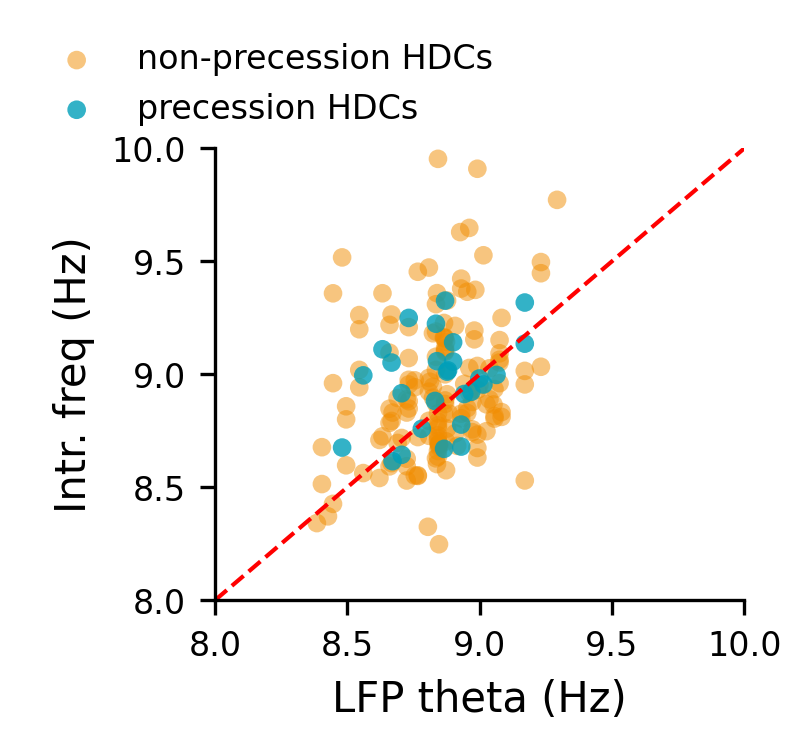

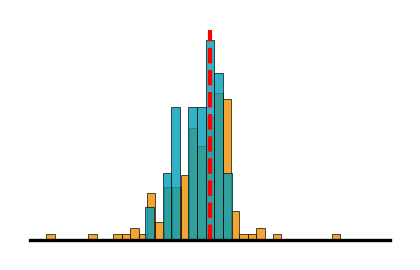

In [12]:
fig, ax = plt.subplots(figsize=(2.8, 2.8), dpi=300)

#filter theta_intrinsic_freq and theta_global_freq by their p < 0.05 and clr < 0

indx_pp = np.where((np.array(theta_ppp) < 0.05) 
                    & (np.array(theta_clr) < 0)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]

#for cells with theta_ppp > 0.05, global freq > 7.2 and global freq < 11.8
indx_nonpp1 = np.where((np.array(theta_ppp) > 0.05)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]
#or cells with theta_ppp < 0.05 & theta_clr >=0 and global freq > 7.2 and global freq < 11.8
indx_nonpp2 = np.where((np.array(theta_ppp) < 0.05)
                    & (np.array(theta_clr) >= 0)
                    & (np.array(theta_global_freq) >= 7.2)
                    & (np.array(theta_global_freq) <= 11.8))[0]
#combine them
indx_nonpp = np.concatenate((indx_nonpp1, indx_nonpp2)) 


ax.scatter(np.array(theta_global_freq)[indx_nonpp],
           np.array(theta_intrinsic_freq)[indx_nonpp],
           color='#F18D00', label='non-precession HDCs', s=20, alpha=0.5, edgecolors='none')

ax.scatter(np.array(theta_global_freq)[indx_pp],
           np.array(theta_intrinsic_freq)[indx_pp],
           color='#009FB9', label='precession HDCs', s=20, alpha=0.8, edgecolors='none')

ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.1, 1.3))

#add y=x
ax.plot([8, 10], [8, 10], color='red', linestyle='--', linewidth=1.0)

ax.set_xlim(8, 10)
ax.set_ylim(8, 10)
ax.set_xlabel('LFP theta (Hz)', fontsize=labelsize)
ax.set_ylabel('Intr. freq (Hz)', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/intrinsic_vs_global_freq.pdf')


# fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)
# #do a histogram plot of the difference between global freq - intrinsic freq
# diff = np.array(theta_global_freq) - np.array(theta_intrinsic_freq)

# diff_nonpp = diff[indx_nonpp]
# bins = np.linspace(-2, 2, 40)
# ax.hist(diff_nonpp, bins=bins, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='non-precession cells')


# diff_pp = diff[indx_pp]
# bins = np.linspace(-1, 1, 20)
# #throw away the outliers if np.abs(diff_pp)>4
# ax.hist(diff_pp, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='precession cells')

# ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))

# #x=0
# ax.axvline(x=0, color='red', linestyle='--', linewidth=1.0)

# ax.set_xlabel('Global - Intr. freq. (Hz)', fontsize=labelsize)
# ax.set_ylabel('Prob. density', fontsize=labelsize)
# ax.spines['top'].set_visible(False)
# ax.spines['right'].set_visible(False)

# #tick size
# ax.tick_params(axis='x', which='major', labelsize=ticksize)
# ax.tick_params(axis='y', which='major', labelsize=ticksize)

# #compare diff_nonpp and diff_pp using mannwhitneyu test
# _, pval = mannwhitneyu(diff_nonpp, diff_pp)
# print('pval between nonpp and pp:', pval)

# #diff_nonpp againt 0 using wilcoxon signed rank test
# _, pval = wilcoxon(diff_nonpp)
# print('pval between nonpp and 0:', pval)

# #diff_pp againt 0 using wilcoxon signed rank test
# _, pval = wilcoxon(diff_pp)
# print('pval between pp and 0:', pval)

# plt.tight_layout()

# plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/global_vs_intrinsic_freq_histogram.pdf')


fig, ax = plt.subplots(1, 1, figsize=(1.5, 1.0), dpi=300)
#do a histogram plot of the difference between global freq - intrinsic freq
diff = np.array(theta_global_freq) - np.array(theta_intrinsic_freq)

diff_nonpp = diff[indx_nonpp]
bins = np.linspace(-2, 2, 40)
ax.hist(diff_nonpp, bins=bins, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='non-precession cells')


diff_pp = diff[indx_pp]
bins = np.linspace(-1, 1, 20)
#throw away the outliers if np.abs(diff_pp)>4
ax.hist(diff_pp, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='precession cells')

# ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))

#x=0
ax.axvline(x=0, color='red', linestyle='--', linewidth=1.0)

ax.set_xlabel('', fontsize=labelsize)
ax.set_ylabel('', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)


#ticks off
ax.set_xticks([])
ax.set_yticks([])

#tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

#compare diff_nonpp and diff_pp using mannwhitneyu test
_, pval = mannwhitneyu(diff_nonpp, diff_pp)
print('pval between nonpp and pp:', pval)

#diff_nonpp againt 0 using wilcoxon signed rank test
_, pval = wilcoxon(diff_nonpp)
print('pval between nonpp and 0:', pval)

#diff_pp againt 0 using wilcoxon signed rank test
_, pval = wilcoxon(diff_pp)
print('pval between pp and 0:', pval)

plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/global_vs_intrinsic_freq_histogram.pdf')

## Section 4.3: check the degree of phase precession against intrinsic frequency

r: -0.07949112713718501 p: 0.6167880871167384


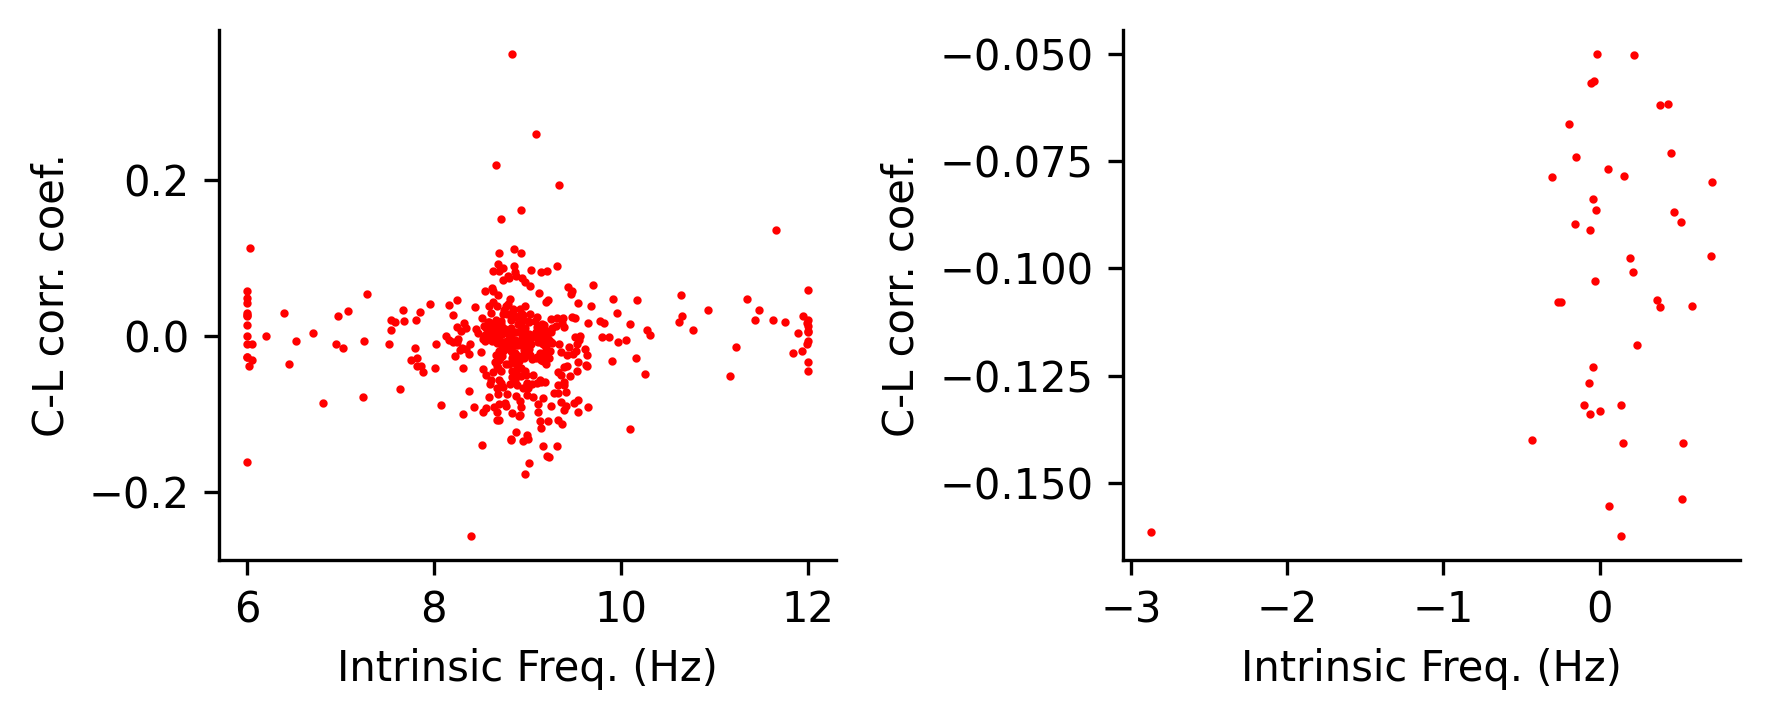

In [13]:
#plot intrinsic frequency against circ-linear correlation for all cells

fig, axs = plt.subplots(1,2,figsize=(6, 2.5), dpi=300)

ax = axs[0]
#plot intrinsic freq against circ-linear correlation for all cells
ax.scatter(all_intrinsic_freq, all_clr, color='red', label='All', s=1)

ax = axs[1]
#do this only for theta_ppp<0.05 and clr<0
indx = np.where((np.array(all_ppp) < 0.05) 
                & (np.array(all_clr) < 0)
                & (np.array(all_global_freq) >= 7.2)
                & (np.array(all_global_freq) <= 11.8))[0]

ax.scatter(np.array(all_intrinsic_freq)[indx]-np.array(all_global_freq)[indx], np.array(all_clr)[indx], color='red', label='All', s=1)

#correlation test between np.array(all_intrinsic_freq)[indx] and np.array(all_clr)[indx]

from scipy.stats import spearmanr
r, p = spearmanr(np.array(all_intrinsic_freq)[indx], np.array(all_clr)[indx])
print('r:', r, 'p:', p)

for ax in axs:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel('Intrinsic Freq. (Hz)', fontsize=labelsize)
    ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
    
plt.tight_layout()

## Section 5: demonstration of sin wave fitting to the autocorrelogram of spike train

Intrinsic Theta Frequency: 8.40 Hz


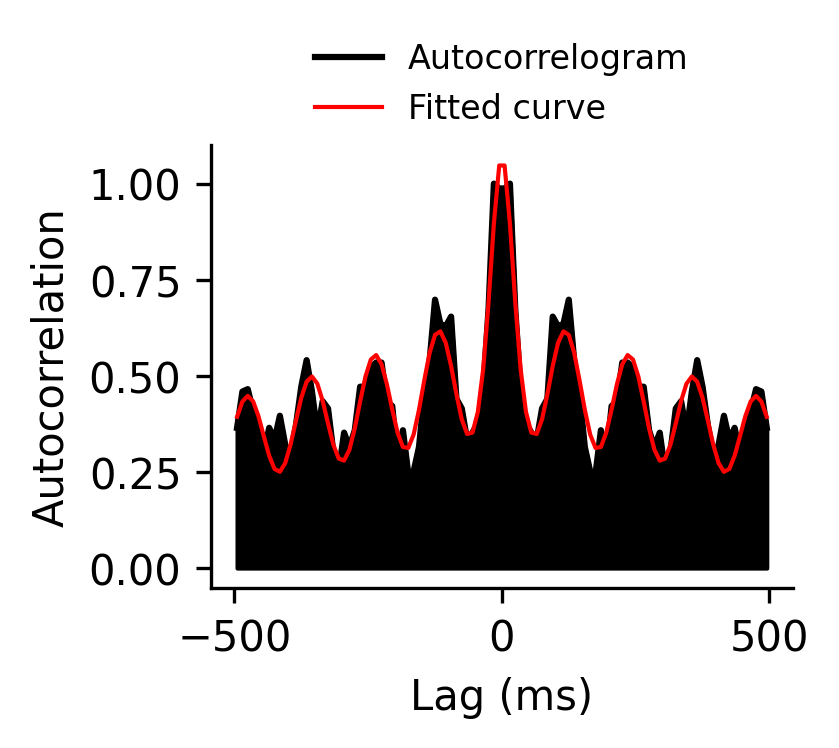

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.8), dpi=300)

ax = plot_autocorrelogram(ax, autocorrelogram)
#set tick fontsize



plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/autocorrelogram.pdf')

In [15]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/autocorrrelogram/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 20,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)
                                ax, intrinsic_frequency = plot_autocorrelogram(ax, autocorrelogram)
                                
                                output_path = os.path.join(output_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
 
                                    if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                        output_skip_path = os.path.join(output_skip_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                        plt.savefig(output_skip_path)
                                    elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                        output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                        plt.savefig(output_nonskip_path)
                                elif cell_type == ' HDC ':
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}--{np.round(intrinsic_frequency, 2)}Hz.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Intrinsic Theta Frequency: 9.83 Hz
Intrinsic Theta Frequency: 7.39 Hz
Intrinsic Theta Frequency: 8.64 Hz
Intrinsic Theta Frequency: 8.62 Hz
Intrinsic Theta Frequency: 8.64 Hz
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Intrinsic Theta Frequency: 9.42 Hz
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Intrinsic Theta Frequency: 10.84 Hz
Intrinsic Theta Frequency: 9.55 Hz
Intrinsic Theta Frequency: 9.65 Hz
Intrinsic Theta Frequency: 9.62 Hz
Intrinsic Theta Frequency: 10.64 Hz
Processing /home/zilong/Desktop/HDPhaseP

## Now calculate theta skipping index and analyse the relationship between skipping index and and the degree of phase precession

Omega: 8.40 Hz
Theta Cycle Skipping Index: -0.08


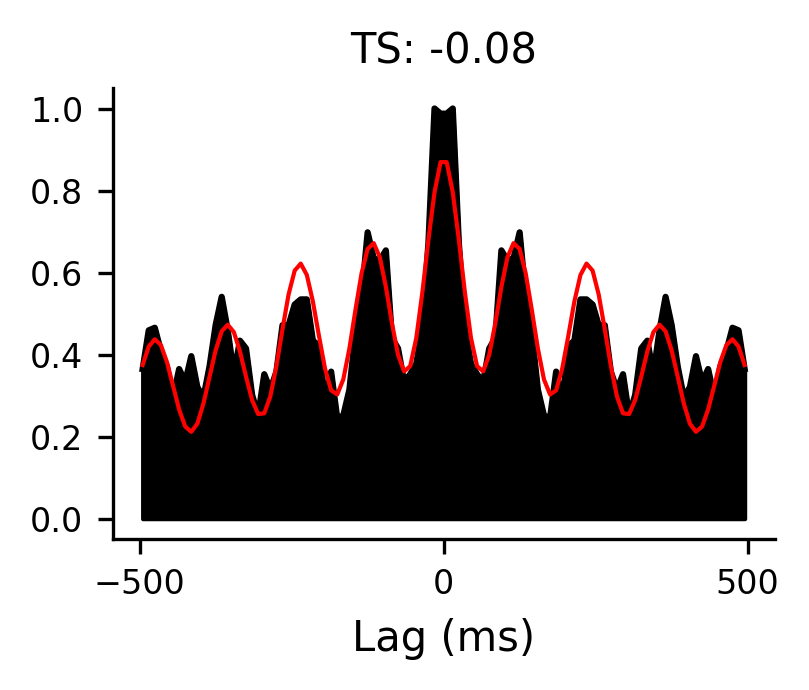

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.4), dpi=300)

ax = plot_thetaskipping(ax, autocorrelogram)
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping.pdf')

    

In [ ]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 20,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []

theta_clr = []
theta_nonskip_clr = []
theta_skip_clr = []

theta_TS = []
theta_nonskip_TS = []
theta_skip_TS = []

theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []

theta_ATI_widthshift = []
theta_nonskip_ATI_widthshift = []
theta_skip_ATI_widthshift = []
nontheta_ATI_widthshift = []

theta_ATI_cwccw = []
theta_nonskip_ATI_cwccw = []
theta_skip_ATI_cwccw = []
nontheta_ATI_cwccw = []

total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        ATI_widthshift = cell_data['ATI_widthshift'][0][0]
                        ATI_cwccw = cell_data['ATI_cwccw'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                #get results for phase precession against tuning angle
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                fig = plt.figure(figsize=(4.2, 1.5), dpi=300)
                                gs=fig.add_gridspec(1, 3, width_ratios=[2, 2, 1.5])
                                
                                ax0 = fig.add_subplot(gs[0], projection='polar')
                                #head direction tuning curve
                                ax0 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                
                                ax1 = fig.add_subplot(gs[1])
                                #plot theta skipping
                                ax1, TS = plot_thetaskipping(ax1, autocorrelogram)
                                
                                ax2 = fig.add_subplot(gs[2])
                                #plot phase precession
                                ax2, pval, clr = plot_phaseprecession(ax2, ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                            
                                output_path = os.path.join(output_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
                                    #if pval<0.05 and clr<0: 
                                    if True:
                                    
                                        theta_ppp.append(pval)
                                        theta_clr.append(clr)
                                        theta_TS.append(TS)
                                        theta_tw.append(tune_width)
                                        theta_ATI_widthshift.append(ATI_widthshift)
                                        theta_ATI_cwccw.append(ATI_cwccw)
                                        
                                        if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                            theta_skip_ppp.append(pval)
                                            theta_skip_clr.append(clr)
                                            theta_skip_TS.append(TS)
                                            theta_skip_tw.append(tune_width)
                                            theta_skip_ATI_widthshift.append(ATI_widthshift)
                                            theta_skip_ATI_cwccw.append(ATI_cwccw)
                                            output_skip_path = os.path.join(output_skip_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                            plt.savefig(output_skip_path)
                                        elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                            theta_nonskip_ppp.append(pval)
                                            theta_nonskip_clr.append(clr)
                                            theta_nonskip_TS.append(TS)
                                            theta_nonskip_tw.append(tune_width)
                                            theta_nonskip_ATI_widthshift.append(ATI_widthshift)
                                            theta_nonskip_ATI_cwccw.append(ATI_cwccw)
                                            output_nonskip_path = os.path.join(output_nonskip_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                            plt.savefig(output_nonskip_path)
                                elif cell_type == ' HDC ':
                                    nontheta_ATI_widthshift.append(ATI_widthshift)
                                    nontheta_ATI_cwccw.append(ATI_cwccw)
                                    output_nontheta_path = os.path.join(output_nontheta_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                    plt.savefig(output_nontheta_path)
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.12
Omega: 8.24 Hz
Theta Cycle Skipping Index: -0.07
Omega: 8.26 Hz
Theta Cycle Skipping Index: -0.12
Omega: 8.29 Hz
Theta Cycle Skipping Index: -0.19
Omega: 8.73 Hz
Theta Cycle Skipping Index: 0.17
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Omega: 9.55 Hz
Theta Cycle Skipping Index: 0.03
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Omega: 9.27 Hz
Theta Cycle Skipping Index: -0.09
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.12
Omega: 6.81 Hz
Theta Cycle Skipping I

r: -0.1413883734232876 p: 0.4178432482692235
r: -0.39976408774316413 p: 0.17593019165760446
r: -0.11151464306300006 p: 0.6212607601183888


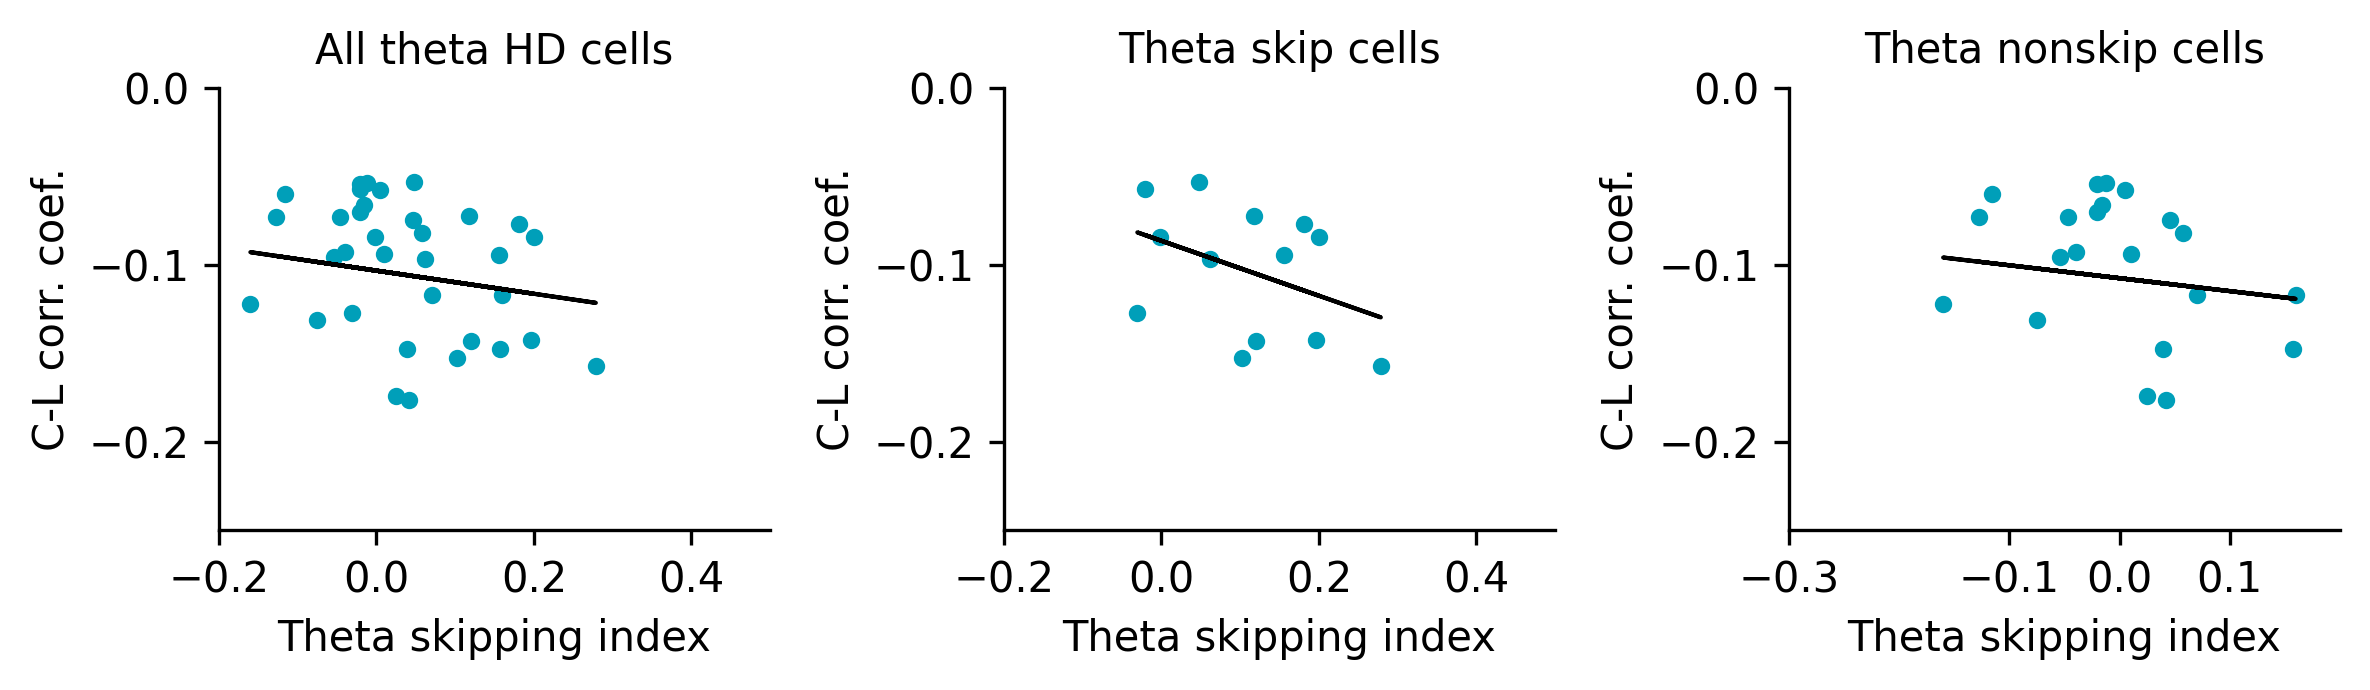

In [ ]:
#plot theta_clr against theta_TS for theta_ppp<0.05
fig, axs = plt.subplots(1, 3, figsize=(8, 2.4), dpi=300)
labelsize = 10

ax = axs[0]
indx = np.where((np.array(theta_ppp) < 0.05) & (np.array(theta_clr) < 0))[0]
ax.scatter(np.array(theta_TS)[indx], np.array(theta_clr)[indx], color='#009FB9', label='Theta', s=10)
#add a linear fit line using polyfit
x = np.array(theta_TS)[indx]
y = np.array(theta_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('All theta HD cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_TS)[indx], np.array(theta_clr)[indx])
print('r:', r, 'p:', p)

ax = axs[1]
indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_TS)[indx]
y = np.array(theta_skip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('Theta skip cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx])
print('r:', r, 'p:', p)

ax = axs[2]
indx = np.where((np.array(theta_nonskip_ppp) < 0.05) & (np.array(theta_nonskip_clr) < 0))[0]
ax.scatter(np.array(theta_nonskip_TS)[indx], np.array(theta_nonskip_clr)[indx], color='#009FB9', label='Theta nonskip', s=10)
#add a linear fit line using polyfit
x = np.array(theta_nonskip_TS)[indx]
y = np.array(theta_nonskip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.3, 0.2])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.3, -0.1, 0, 0.1])
ax.set_yticks([-0.2, -0.1, 0])
ax.set_title('Theta nonskip cells', fontsize=labelsize)

r, p = pearsonr(np.array(theta_nonskip_TS)[indx], np.array(theta_nonskip_clr)[indx])
print('r:', r, 'p:', p)

for ax in axs:
    ax.set_xlabel('Theta skipping index', fontsize=labelsize)
    ax.set_ylabel('C-L corr. coef.', fontsize=labelsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()


r: -0.39976408774316413 p: 0.17593019165760446


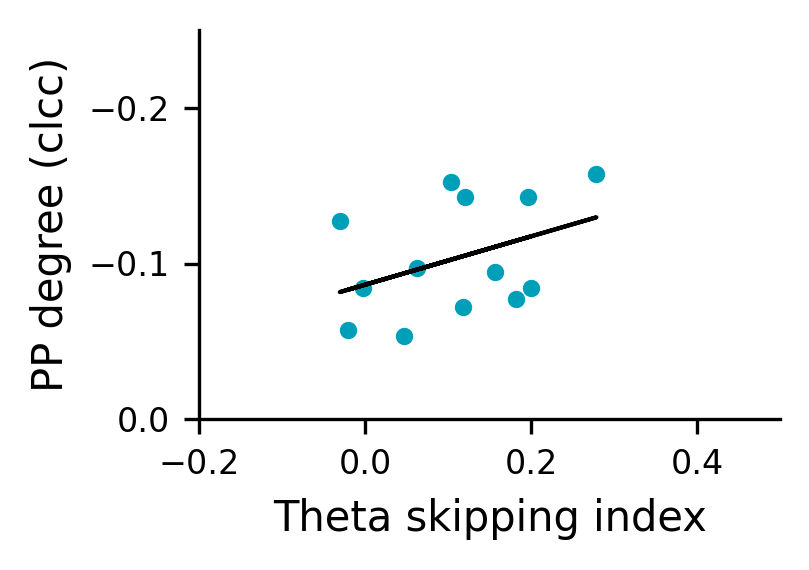

In [ ]:
#plot theta_clr against theta_TS for theta_ppp<0.05
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.0), dpi=300)
labelsize = 10 
ticksize = 8

indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_TS)[indx]
y = np.array(theta_skip_clr)[indx]
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.2, 0.5])
ax.set_ylim([-0.25,0.0])
ax.set_xticks([-0.2, 0, 0.2, 0.4])
ax.set_yticks([-0.2, -0.1, 0])

#invese y 
ax.invert_yaxis()

#set x and y tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)
ax.tick_params(axis='y', which='major', labelsize=ticksize)

r, p = pearsonr(np.array(theta_skip_TS)[indx], np.array(theta_skip_clr)[indx])
print('r:', r, 'p:', p)

ax.set_ylabel('PP degree (clcc)', fontsize=labelsize)
ax.set_xlabel('Theta skipping index', fontsize=labelsize)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
plt.tight_layout()

plt.savefig('/home/zilong/Desktop/HDPhasePrecession/figures/theta_TS_vs_clr.pdf')

## Check ATI againt skipping index

r: -0.049688135303689464 p: 0.8719365848071658


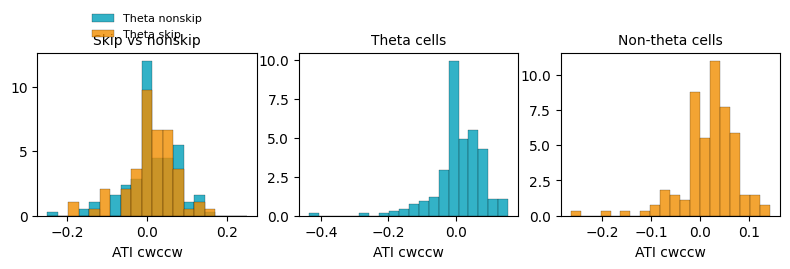

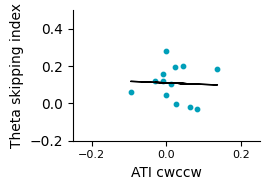

In [ ]:
#plot theta_nonskip_ATI_widthshift and theta_skip_ATI_widthshift in the same histogram
fig, axs = plt.subplots(1, 3, figsize=(8, 3.0), dpi=100)
labelsize = 10
ticksize = 8


ax = axs[0]
bins = np.linspace(-0.25, 0.25, 20)
ax.hist(theta_nonskip_ATI_cwccw, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta nonskip')
ax.hist(theta_skip_ATI_cwccw, bins=bins, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta skip')

ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
ax.set_xlabel('ATI cwccw', fontsize=labelsize)
ax.set_title('Skip vs nonskip', fontsize=labelsize)

#plot ATI_cwccw for theta
ax = axs[1]
ax.hist(theta_ATI_cwccw, bins=20, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta')
ax.set_xlabel('ATI cwccw', fontsize=labelsize)
ax.set_title('Theta cells', fontsize=labelsize)

ax = axs[2]
ax.hist(nontheta_ATI_cwccw, bins=20, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Non-theta')
ax.set_xlabel('ATI cwccw', fontsize=labelsize)
ax.set_title('Non-theta cells', fontsize=labelsize)


plt.tight_layout()

#plot ATI against theta_TS for theta_ppp<0.05
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.0), dpi=100)
indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_ATI_cwccw)[indx], np.array(theta_skip_TS)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_ATI_cwccw)[indx]
y = np.array(theta_skip_TS)[indx]

m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.25, 0.25])
ax.set_ylim([-0.2,0.5])
ax.set_xticks([-0.2, 0, 0.2])
ax.set_yticks([-0.2, 0, 0.2, 0.4])

#set x and y tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)

r, p = pearsonr(np.array(theta_skip_ATI_cwccw)[indx], np.array(theta_skip_TS)[indx])
print('r:', r, 'p:', p)

ax.set_ylabel('Theta skipping index', fontsize=labelsize)
ax.set_xlabel('ATI cwccw', fontsize=labelsize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


r: 0.4454557737296763 p: 0.12714021015720223


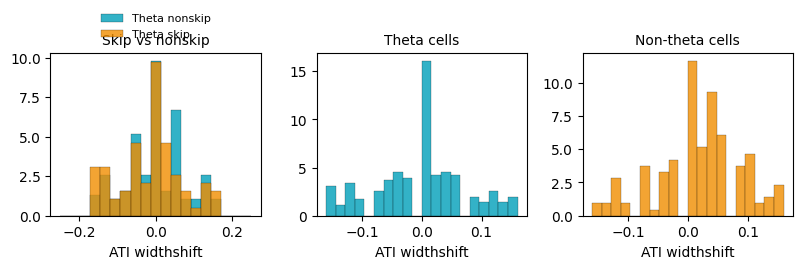

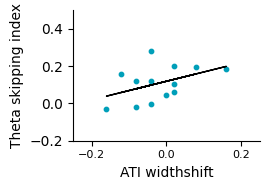

In [ ]:
#plot theta_nonskip_ATI_widthshift and theta_skip_ATI_widthshift in the same histogram
fig, axs = plt.subplots(1, 3, figsize=(8, 3.0), dpi=100)
labelsize = 10
ticksize = 8


ax = axs[0]
bins = np.linspace(-0.25, 0.25, 20)
ax.hist(theta_nonskip_ATI_widthshift, bins=bins, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta nonskip')
ax.hist(theta_skip_ATI_widthshift, bins=bins, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta skip')

ax.legend(frameon=False, loc='upper center', fontsize=8, ncol=1, bbox_to_anchor=(0.5, 1.3))
ax.set_xlabel('ATI widthshift', fontsize=labelsize)
ax.set_title('Skip vs nonskip', fontsize=labelsize)

#plot ATI_cwccw for theta
ax = axs[1]
ax.hist(theta_ATI_widthshift, bins=20, color='#009FB9', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Theta')
ax.set_xlabel('ATI widthshift', fontsize=labelsize)
ax.set_title('Theta cells', fontsize=labelsize)

ax = axs[2]
ax.hist(nontheta_ATI_widthshift, bins=20, color='#F18D00', edgecolor='black', linewidth=0.2, alpha=0.8, density=True, label='Non-theta')
ax.set_xlabel('ATI widthshift', fontsize=labelsize)
ax.set_title('Non-theta cells', fontsize=labelsize)


plt.tight_layout()

#plot ATI against theta_TS for theta_ppp<0.05
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.0), dpi=100)
indx = np.where((np.array(theta_skip_ppp) < 0.05) & (np.array(theta_skip_clr) < 0))[0]
ax.scatter(np.array(theta_skip_ATI_widthshift)[indx], np.array(theta_skip_TS)[indx], color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_skip_ATI_widthshift)[indx]
y = np.array(theta_skip_TS)[indx]

m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlim([-0.25, 0.25])
ax.set_ylim([-0.2,0.5])
ax.set_xticks([-0.2, 0, 0.2])
ax.set_yticks([-0.2, 0, 0.2, 0.4])

#set x and y tick size
ax.tick_params(axis='x', which='major', labelsize=ticksize)

r, p = pearsonr(np.array(theta_skip_ATI_widthshift)[indx], np.array(theta_skip_TS)[indx])
print('r:', r, 'p:', p)

ax.set_ylabel('Theta skipping index', fontsize=labelsize)
ax.set_xlabel('ATI widthshift', fontsize=labelsize)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


## Section 6: Check skipping index vs tuning width

In [ ]:
base_dir = '/home/zilong/Desktop/HDPhasePrecession/LomiData'
output_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/all/'
output_skip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/skip/'
output_nonskip_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nonskip/'
output_nontheta_dir = '/home/zilong/Desktop/HDPhasePrecession/figures/thetaskipping/nontheta/'

# Configuration
config = {
    'hd_bins': 60,
    'hd_boxcar': 3,
    'speed_threshold': 0.5,
    'duration_threshold': 0.5,
    'speed_smooth_sigma': 20,  #0.8,0.8,40 gives 43% pp cells
    'movingdirection_sigma': 5, #time bin size 20 ms, so 5 is 100 ms
    'interpolation_factor': 1, #1 is 0.02s, and 2 is 0.01s
    'IFR_window':0.2
}

# Create output directories if they don't exist
for dir_path in [output_dir, output_skip_dir, output_nonskip_dir, output_nontheta_dir]:
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)    
    os.makedirs(dir_path)

theta_ppp = []
theta_nonskip_ppp = []
theta_skip_ppp = []

theta_clr = []
theta_nonskip_clr = []
theta_skip_clr = []

theta_TS = []
theta_nonskip_TS = []
theta_skip_TS = []

theta_tw = []
theta_nonskip_tw = []
theta_skip_tw = []


total_hd_cells = 0

matnames = {}

# Iterate through each subfolder in the base directory
for subdir in os.listdir(base_dir):
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        # Iterate through each .mat file in the subfolder
        for file in os.listdir(subdir_path):
            if file.endswith('_sdata.mat'):
                file_path = os.path.join(subdir_path, file)
                print(f"Processing {file_path}")
                ratname = file.split('_')[0]
                data_dict = HD_utils.load_data(ratname, file_path)
                
                if data_dict is not None:
                    ppoh = data_dict['poh']
                    pot = data_dict['pot'].flatten()
                    
                    ppox = data_dict['ppox'].flatten()
                    ppoy = data_dict['ppoy'].flatten()
                    global_freq = data_dict['global_freq'][0][0]
                    
                    #interpolte pot 
                    sampling_interval = np.diff(pot).mean()
                    new_interval = sampling_interval / config['interpolation_factor']
                    pot_interp = np.arange(0, pot[-1], new_interval)
                    
                    for cell_name, cell_data in data_dict['cells_data'].items():
                        psph = cell_data['psph'].flatten()
                        pspt = cell_data['pspt'].flatten()
                        spike_phase = cell_data['spike_phase'].flatten()
                        hd_pval = cell_data['pval'][0][0]
                        hd_mean = cell_data['hd_mean'][0][0]
                        hd_std = cell_data['hd_std'][0][0]
                        tune_width = cell_data['tune_width'][0][0]
                        autocorrelogram = cell_data['autocorrelogram']
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        hd_rayleigh = cell_data['hd_rayleigh'][0][0]
                        hd_rayleigh_shuffle_99 = cell_data['hd_rayleigh_shuffle_99'][0][0]
                        peak_fr = cell_data['peak_fr'][0][0]
                        intrinsic_freq = cell_data['intrinsic_freq'][0][0]
                        cell_type = cell_data['cell_type']
                        
                        #store matname for each cell
                        matnames[cell_name] = [ratname, file_path]
                        
                        #if hd_pval < 0.05: #select only head direction tuned cells
                        if hd_rayleigh > hd_rayleigh_shuffle_99 and peak_fr > 1: #select only head direction tuned cells with rayleigh vector > 99% shuffle and the peak firing rate in the directional field is greater than 1 Hz
                            try:
                                #get results for phase precession against tuning angle
                                pval, clr = get_phaseprecession(ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                                
                                fig = plt.figure(figsize=(4.2, 1.5), dpi=300)
                                gs=fig.add_gridspec(1, 3, width_ratios=[2, 2, 1.5])
                                
                                ax0 = fig.add_subplot(gs[0], projection='polar')
                                #head direction tuning curve
                                ax0 = plot_head_direction_tuning(ax0, ppoh, psph, config)
                                
                                ax1 = fig.add_subplot(gs[1])
                                #plot theta skipping
                                ax1, TS = plot_thetaskipping(ax1, autocorrelogram)
                                
                                ax2 = fig.add_subplot(gs[2])
                                #plot phase precession
                                ax2, pval, clr = plot_phaseprecession(ax2, ppoh, pot, pspt, psph, hd_mean, spike_phase, config)
                            
                                output_path = os.path.join(output_dir, f"{cell_name}@{np.round(TS, 2)}.pdf")
                                
                                plt.tight_layout()
                                plt.savefig(output_path)
                            
                                #save fig according to cell type in different folders
                                if cell_type == ' Strong ThetaxHD ' or cell_type == ' Strong ThetaxHD  & skip': #This is a theta modulated HD cell
                                    theta_ppp.append(pval)
                                    theta_clr.append(clr)
                                    theta_TS.append(TS)
                                    theta_tw.append(tune_width)
                                    
                                    if cell_type == ' Strong ThetaxHD  & skip': #this is a theta skipping cell
                                        theta_skip_ppp.append(pval)
                                        theta_skip_clr.append(clr)
                                        theta_skip_TS.append(TS)
                                        theta_skip_tw.append(tune_width)

                                    elif cell_type == ' Strong ThetaxHD ': #this is a theta modulated non-skipping cell
                                        theta_nonskip_ppp.append(pval)
                                        theta_nonskip_clr.append(clr)
                                        theta_nonskip_TS.append(TS)
                                        theta_nonskip_tw.append(tune_width)

                                elif cell_type == ' HDC ':
                                    pass
                                    
                                plt.close(fig)
                                total_hd_cells += 1
                            except Exception as e:
                                plt.close(fig)
                                print(f"Error processing {cell_name}: {e}")
                        
print(f"Total number of HD cells processed: {total_hd_cells}")


Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_170719_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_100919_T1_sdata.mat
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.12
Omega: 8.24 Hz
Theta Cycle Skipping Index: -0.07
Omega: 8.26 Hz
Theta Cycle Skipping Index: -0.12
Omega: 8.29 Hz
Theta Cycle Skipping Index: -0.19
Omega: 8.73 Hz
Theta Cycle Skipping Index: 0.17
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
light1 not found in /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_040919_T1_sdata.mat
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_250719_T1_sdata.mat
Omega: 9.55 Hz
Theta Cycle Skipping Index: 0.03
Processing /home/zilong/Desktop/HDPhasePrecession/LomiData/DATA r652/R652_090819_T1_sdata.mat
Omega: 9.27 Hz
Theta Cycle Skipping Index: -0.09
Omega: 6.00 Hz
Theta Cycle Skipping Index: -0.12
Omega: 6.81 Hz
Theta Cycle Skipping I

r: 0.1362030686091186 p: 0.04309812638937329


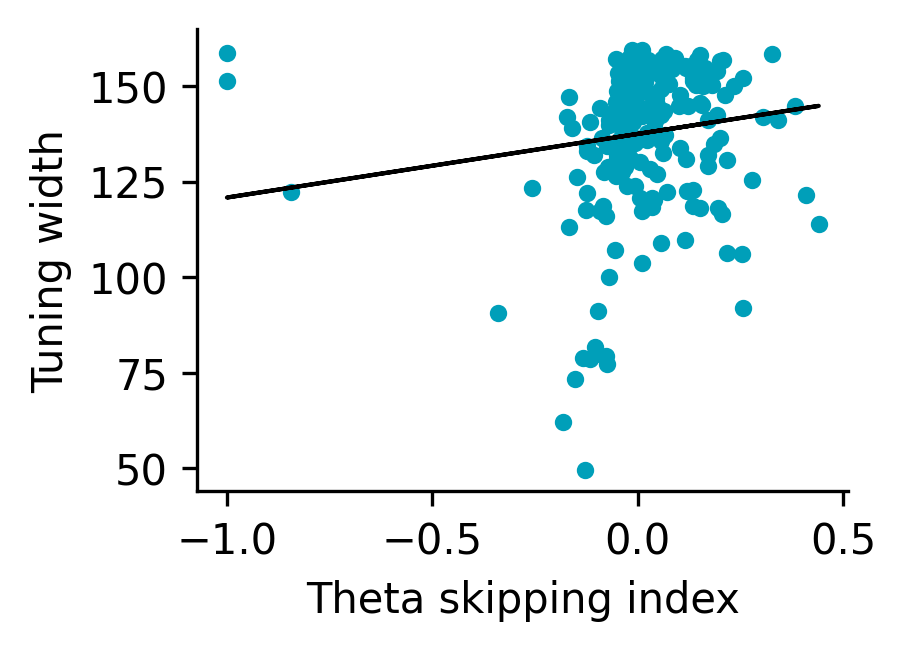

In [ ]:
#scatter plot of theta_TS against theta_tw
fig, ax = plt.subplots(1, 1, figsize=(2.8, 2.0), dpi=300)
labelsize = 10
ticksize = 8

ind = np.where((np.array(theta_ppp) < 0.05) & (np.array(theta_clr) < 0))[0]
# ax.scatter(np.array(theta_TS)[ind], np.array(theta_tw)[ind], color='#009FB9', label='Theta', s=10)
ax.scatter(np.array(theta_TS), np.array(theta_tw), color='#009FB9', label='Theta skip', s=10)

#add a linear fit line using polyfit
x = np.array(theta_TS)
y = np.array(theta_tw)
m, b = np.polyfit(x, y, 1)
ax.plot(x, m*x + b, color='k', linestyle='-', linewidth=1.0)

ax.set_xlabel('Theta skipping index', fontsize=labelsize)
ax.set_ylabel('Tuning width', fontsize=labelsize)

#pearson correlation
r, p = pearsonr(np.array(theta_TS), np.array(theta_tw))
print('r:', r, 'p:', p)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
